In [1]:
import numpy as np
import heartpy as hp
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
from scipy.signal import argrelextrema
from scipy import integrate

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the datasets
mat = scipy.io.loadmat(r"C:\Users\nitar\OneDrive - Virginia Tech\BMES 4015\Example ML Algorithms from Lit Reviews\T2TGAN - data\part_1.mat")

In [3]:
records = [record for record in mat['p'][0]]

'''
for each record:
3 types
r[0][i]

The sampling frequency (fs) is the number of samples per second:
1: PPG signal, FS=125Hz; photoplethysmograph from fingertip
2: ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg)
3: ECG signal, FS=125Hz; electrocardiogram from channel II

Ex for records[0][i]: 125 samples/sec ; 61000 samples = 488 sec or ~8 min
'''
#print(len(records[i][j]))

'\nfor each record:\n3 types\nr[0][i]\n\nThe sampling frequency (fs) is the number of samples per second:\n1: PPG signal, FS=125Hz; photoplethysmograph from fingertip\n2: ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg)\n3: ECG signal, FS=125Hz; electrocardiogram from channel II\n\nEx for records[0][i]: 125 samples/sec ; 61000 samples = 488 sec or ~8 min\n'

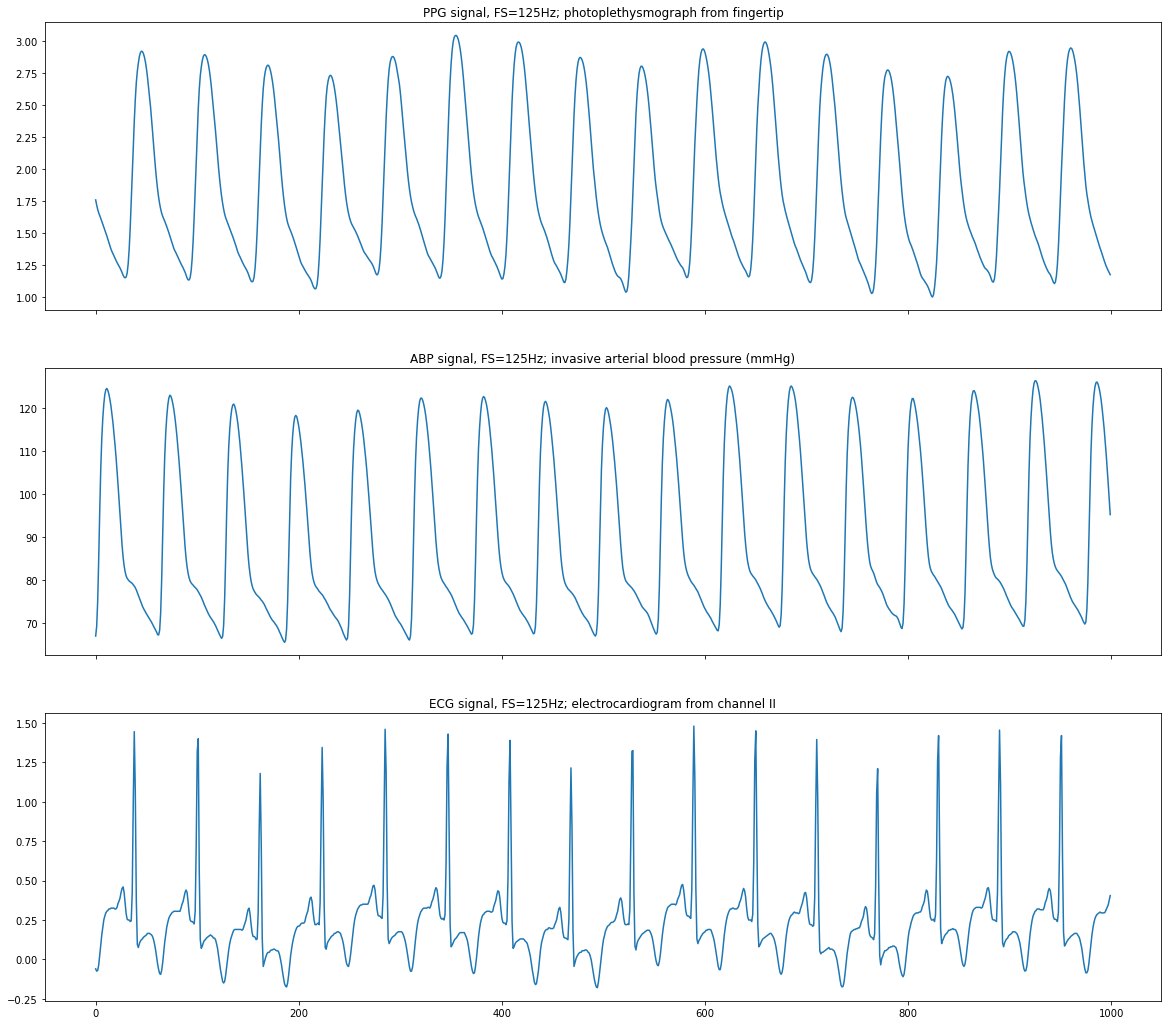

In [4]:
# Create three subplots 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,sharex=True,figsize=(20,18))
# plotting the first 8 seconds of the first record
ax1.plot(records[0][0][:1000])
ax1.title.set_text('PPG signal, FS=125Hz; photoplethysmograph from fingertip')
ax2.plot(records[0][1][:1000])
ax2.title.set_text('ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg)')
ax3.plot(records[0][2][:1000])
ax3.title.set_text('ECG signal, FS=125Hz; electrocardiogram from channel II')

In [5]:
PPG = np.array(records[0][0])
ABP = np.array(records[0][1])
ECG = np.array(records[0][2])

In [6]:
# norm
PPG_norm = preprocessing.minmax_scale(records[0][0],feature_range=(0, 1))

# 1st derivative
PPG_d = np.gradient(PPG_norm)

# 2nd derivative
PPG_sd = np.gradient(PPG_d)

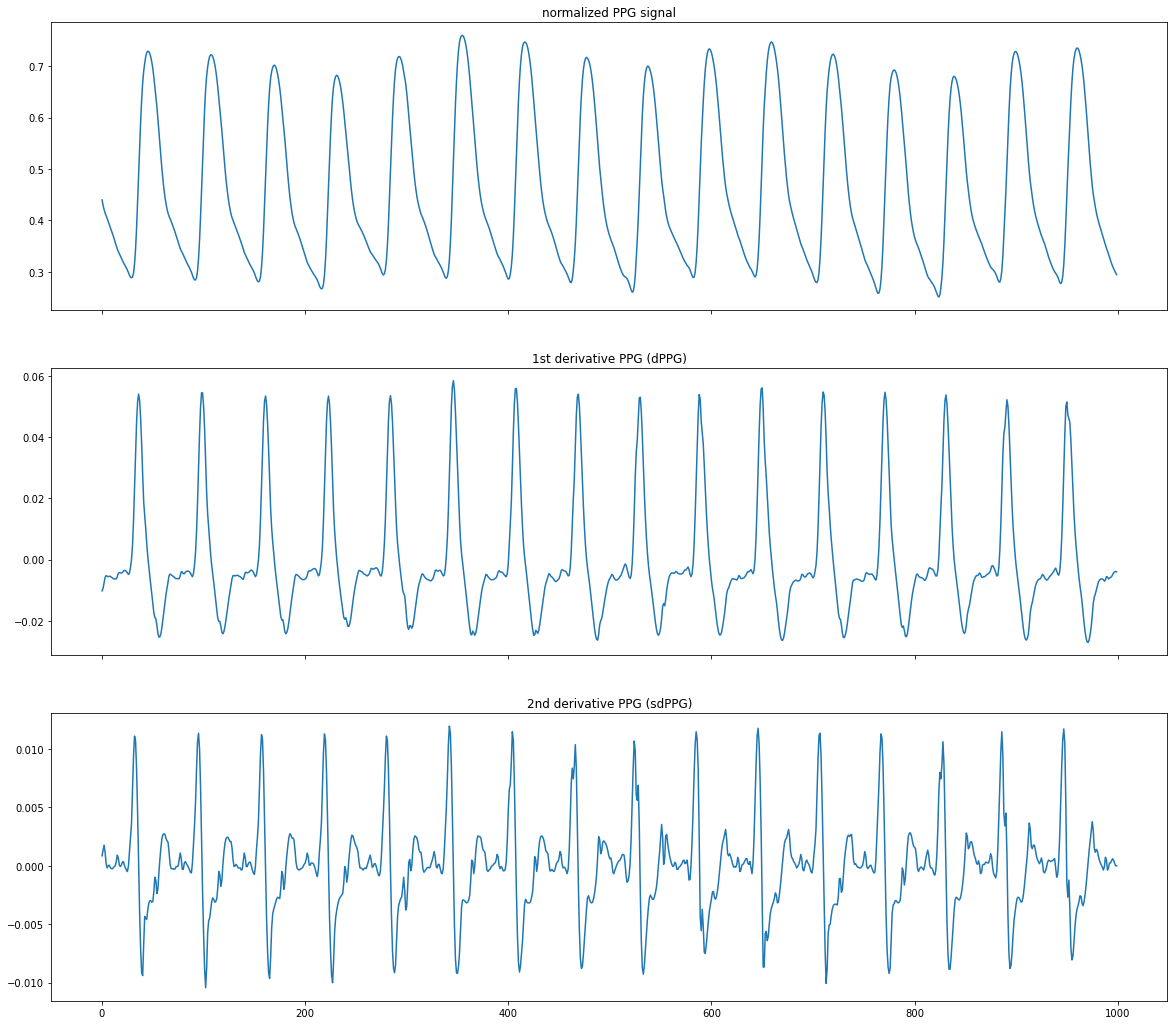

In [7]:
# Create three subplots 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,sharex=True,figsize=(20,18))
# plotting the first 8 seconds of the first record
ax1.plot(PPG_norm[:1000])
ax1.title.set_text('normalized PPG signal')
ax2.plot(PPG_d[:1000])
ax2.title.set_text('1st derivative PPG (dPPG)')
ax3.plot(PPG_sd[:1000])
ax3.title.set_text('2nd derivative PPG (sdPPG)')

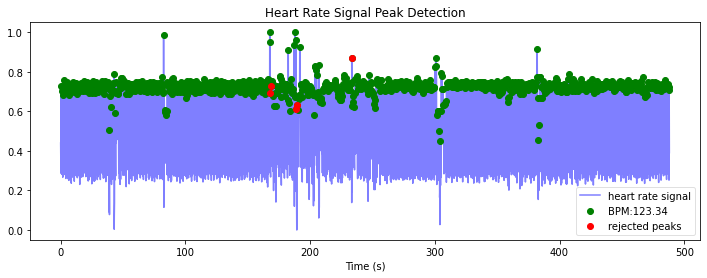

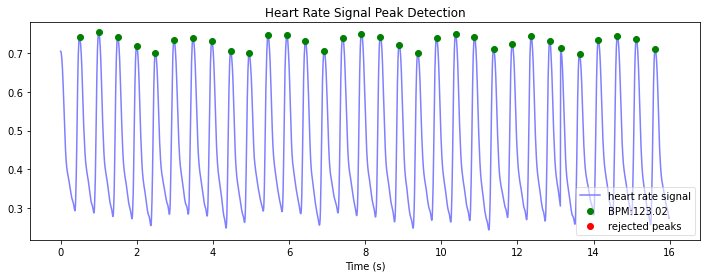

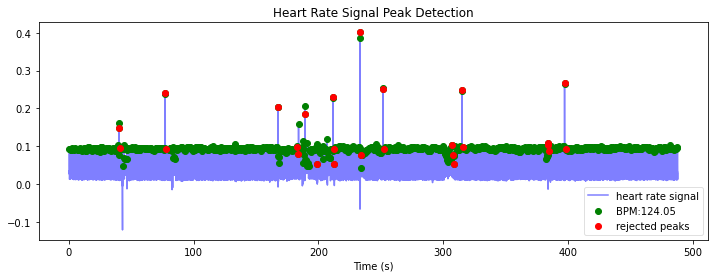

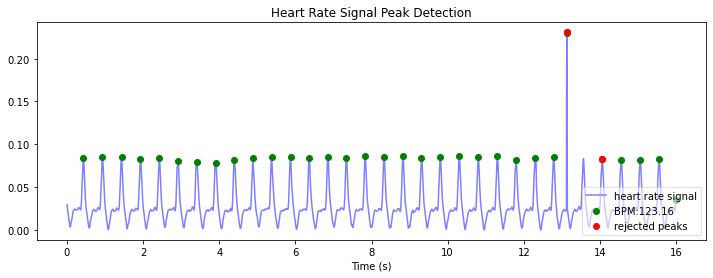

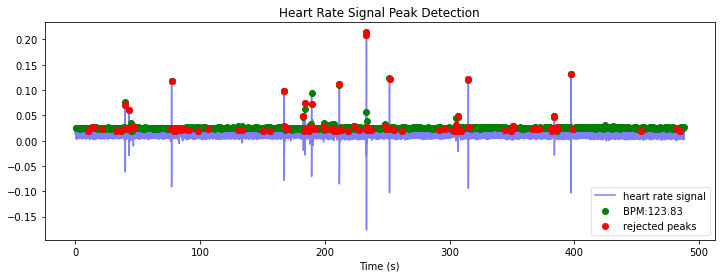

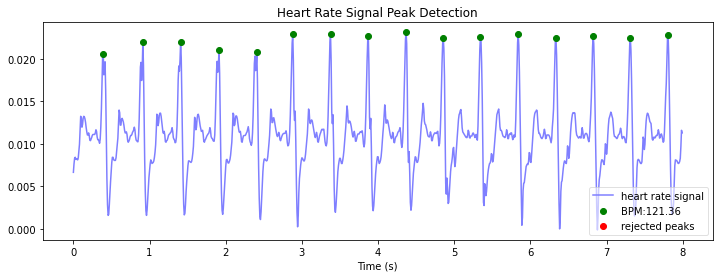

In [8]:
# running the PPG peak detection analysis 
wd1, m1 = hp.process(PPG_norm, sample_rate = 125) # full array
hp.visualizeutils.plotter(wd1, m1, figsize=(12,4))
wd2, m2 = hp.process(PPG_norm[8000:10000], sample_rate = 125) # full array
hp.visualizeutils.plotter(wd2, m2, figsize=(12,4))
wd_d1, m_d1 = hp.process(PPG_d, sample_rate = 125) # full array
hp.visualizeutils.plotter(wd_d1, m_d1, figsize=(12,4))
wd_d2, m_d2 = hp.process(PPG_d[8000:10000], sample_rate = 125) # full array
hp.visualizeutils.plotter(wd_d2, m_d2, figsize=(12,4))
wd_sd1, m_sd1 = hp.process(PPG_sd, sample_rate = 125) # full array
hp.visualizeutils.plotter(wd_sd1, m_sd1, figsize=(12,4))
wd_sd2, m_sd2 = hp.process(PPG_sd[8000:9000], sample_rate = 125) # full array
hp.visualizeutils.plotter(wd_sd2, m_sd2, figsize=(12,4))

In [9]:
# (a) systolic peaks
systolic_peak_idx = wd1['peaklist'] # array of peak indices
systolic_peak = wd1['ybeat'] # array of peak values

In [10]:
# (b1) valley points for PPG
ppg_valley_point_idx = [] # array of valley point indices
ppg_valley_point = [] # array of valley point values
for i in range(len(systolic_peak)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = systolic_peak_idx[i] # index of 1st peak
        ptp = PPG_norm[p1:p2]
        min_val = min(ptp)
        ppg_valley_point.append(min_val)
        min_idx = np.where(ptp == min_val)
        ppg_valley_point_idx.append(min_idx[0][0].tolist()) 
    else: 
        p1 = systolic_peak_idx[i-1] # index of 1st peak
        p2 = systolic_peak_idx[i] # index of 2nd peak
        ptp = PPG_norm[p1:p2]
        min_val = min(ptp)
        ppg_valley_point.append(min_val)
        min_idx = np.where(ptp == min_val) + p1
        ppg_valley_point_idx.append(min_idx[0][0].tolist())

In [11]:
# (b2) valley points and lowest points for dPPG
dppg_peak_idx = wd_d1['peaklist']
dppg_peak = wd_d1['ybeat']
dppg_valley_point_idx = [] # array of valley point indices
dppg_valley_point = [] # array of valley point values
dppg_dDA_point_idx = [] # array of lowest point indices
dppg_dDA_point = [] # array of lowest point value

# valley points
for i in range(len(dppg_peak_idx)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = dppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_d[p1:p2]
        mins = argrelextrema(ptp, np.less)
        dppg_valley_point_idx.append(mins[0][-1])
        dppg_valley_point.append(ptp[mins[0][-1]])
    else:
        p1 = dppg_peak_idx[i-1] # index of 1st peak
        p2 = dppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_d[p1:p2]
        if len(ptp) > 20:
            mins = argrelextrema(ptp, np.less)
            if ptp[mins[0][-1]] != 0:
                dppg_valley_point_idx.append(mins[0][-1] + p1)
                dppg_valley_point.append(ptp[mins[0][-1]])
            
# lowest points
for i in range(len(dppg_peak_idx)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = dppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_d[p1:p2]
        min_val = min(ptp)
        dppg_dDA_point.append(min_val)
        min_idx = np.where(ptp == min_val)
        dppg_dDA_point_idx.append(min_idx[0][0].tolist())
    else:
        p1 = dppg_peak_idx[i-1] # index of 1st peak
        p2 = dppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_d[p1:p2]
        min_val = min(ptp)
        dppg_dDA_point.append(min_val)
        min_idx = np.where(ptp == min_val) + p1
        dppg_dDA_point_idx.append(min_idx[0][0].tolist())

In [12]:
# (b3) valley points and lowest points for sdPPG
sdppg_peak_idx = wd_sd1['peaklist']
sdppg_peak = wd_sd1['ybeat']
sdppg_valley_point_idx = [] # array of valley point indices
sdppg_valley_point = [] # array of valley point values
sdppg_dDA_point_idx = [] # array of lowest point indices
sdppg_dDA_point = [] # array of lowest point value

# valley points
for i in range(len(sdppg_peak_idx)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = sdppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_sd[p1:p2]
        mins = argrelextrema(ptp, np.less)
        sdppg_valley_point_idx.append(mins[0][-1])
        sdppg_valley_point.append(ptp[mins[0][-1]])
    else:
        p1 = sdppg_peak_idx[i-1] # index of 1st peak
        p2 = sdppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_sd[p1:p2]
        if len(ptp) > 20:
            mins = argrelextrema(ptp, np.less)
            if ptp[mins[0][-1]] != 0:
                sdppg_valley_point_idx.append(mins[0][-1] + p1)
                sdppg_valley_point.append(ptp[mins[0][-1]])
            
# lowest points
for i in range(len(sdppg_peak_idx)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = sdppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_sd[p1:p2]
        min_val = min(ptp)
        sdppg_dDA_point.append(min_val)
        min_idx = np.where(ptp == min_val)
        sdppg_dDA_point_idx.append(min_idx[0][0].tolist())
    else:
        p1 = sdppg_peak_idx[i-1] # index of 1st peak
        p2 = sdppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_sd[p1:p2]
        min_val = min(ptp)
        sdppg_dDA_point.append(min_val)
        min_idx = np.where(ptp == min_val) + p1
        sdppg_dDA_point_idx.append(min_idx[0][0].tolist())

In [13]:
# (c) max/min slope values 
slopeval_ppg = [PPG_norm[i] for i in wd_d1['peaklist']]
slopeval_ppg_idx = wd_d1['peaklist']
slopeval_dppg = [PPG_d[i] for i in wd_sd1['peaklist']]
slopeval_dppg_idx = wd_sd1['peaklist']

In [14]:
# (d) dicrotic notch points
dicrotic_notch_idx = scipy.signal.find_peaks(PPG_sd,height=(0.002,0.004),distance=35)[0]
dicrotic_notch = [PPG_norm[i] for i in dicrotic_notch_idx]

In [15]:
## Creating a tuple of the variable tuples following the format described above
data = ()
data = data + ((ppg_valley_point_idx, ppg_valley_point),)
data = data + ((dppg_valley_point_idx, dppg_valley_point),)
data = data + ((sdppg_valley_point_idx, sdppg_valley_point),)
data = data + ((systolic_peak_idx, systolic_peak),)
data = data + ((slopeval_ppg_idx, slopeval_ppg),)
data = data + ((slopeval_dppg_idx, slopeval_dppg),)
data = data + ((dicrotic_notch_idx, dicrotic_notch),)
data = data + ((dppg_dDA_point_idx, dppg_dDA_point),)
data = data + ((sdppg_dDA_point_idx, sdppg_dDA_point),)
data = data + ((dppg_peak_idx, dppg_peak),)
data = data + ((sdppg_peak_idx, sdppg_peak),)

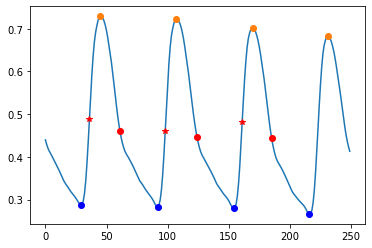

In [16]:
##EXAMPLES FOR HELP
plt.plot(PPG_norm[:250])
plt.plot(systolic_peak_idx[:4],systolic_peak[:4],'o')
plt.plot(ppg_valley_point_idx[:4],ppg_valley_point[:4],'bo')
plt.plot(slopeval_ppg_idx[:3],slopeval_ppg[:3],'r*')
plt.plot(dicrotic_notch_idx[:3],dicrotic_notch[:3],'ro')

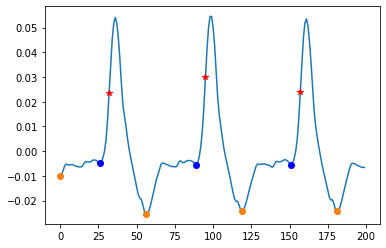

In [17]:
plt.plot(PPG_d[:200])
plt.plot(slopeval_dppg_idx[0:3],slopeval_dppg[0:3],'r*')
plt.plot(dppg_valley_point_idx[0:3], dppg_valley_point[0:3],'bo')
plt.plot(dppg_dDA_point_idx[0:4],dppg_dDA_point[0:4],'o')

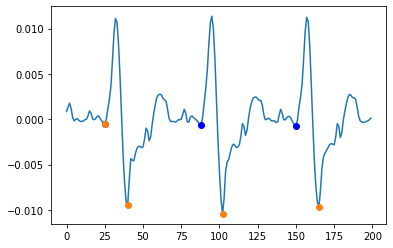

In [18]:
plt.plot(PPG_sd[:200])
plt.plot(sdppg_valley_point_idx[0:3], sdppg_valley_point[0:3],'bo')
plt.plot(sdppg_dDA_point_idx[0:4],sdppg_dDA_point[0:4],'o')

In [19]:
# creating an empty dataframe with labelled columns
df = pd.DataFrame(columns=['onset_valley_point_idx','onset_valley_point',
                           'offset_valley_point_idx','offset_valley_point',
                           'dppg_onset_point_idx','dppg_onset_point',
                           'sdppg_onset_point_idx','sdppg_onset_point',
                           'systolic_peak_idx','systolic_peak',
                           'slopeval_ppg_idx','slopeval_ppg',
                           'slopeval_dppg_idx','slopeval_dppg',
                           'dicrotic_notch_idx','dicrotic_notch',
                           'dppg_dDA_point_idx','dppg_dDA_point',
                           'sdppg_dDA_point_idx','sdppg_dDA_point',
                           'dppg_peak_idx', 'dppg_peak',
                           'sdppg_peak_idx', 'sdppg_peak'
                          ])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   onset_valley_point_idx   0 non-null      object
 1   onset_valley_point       0 non-null      object
 2   offset_valley_point_idx  0 non-null      object
 3   offset_valley_point      0 non-null      object
 4   dppg_onset_point_idx     0 non-null      object
 5   dppg_onset_point         0 non-null      object
 6   sdppg_onset_point_idx    0 non-null      object
 7   sdppg_onset_point        0 non-null      object
 8   systolic_peak_idx        0 non-null      object
 9   systolic_peak            0 non-null      object
 10  slopeval_ppg_idx         0 non-null      object
 11  slopeval_ppg             0 non-null      object
 12  slopeval_dppg_idx        0 non-null      object
 13  slopeval_dppg            0 non-null      object
 14  dicrotic_notch_idx       0 non-null      object
 15  dicrot

In [20]:
# separating each full wave element into a list and then converting the list to a df row 
for i in range(len((data[0][0]))-1):
    row_vals = []
    onset_idx = data[0][0][i]
    onset_val = data[0][1][i]
    offset_idx = data[0][0][i+1]
    offset_val = data[0][1][i+1]
    row_vals.extend([onset_idx,onset_val,offset_idx,offset_val])

    for j in range(1,11):
        idx_index = list(x for x in data[j][0] if onset_idx <= x <= offset_idx)
        if bool(idx_index) == True:
            val_index = np.where(np.asarray(data[j][0])==idx_index[0])
            val = data[j][1][val_index[0][0]]
            row_vals.extend([idx_index[0],val])
        else:
            row_vals.extend([np.nan,np.nan])
    
    # adding the row to the dataframe
    df.loc[i] = row_vals

In [21]:
# create offset values for dPPG and sdPPG
df['dppg_offset_point_idx'] = df['dppg_onset_point_idx'].shift(periods=-1)
df['dppg_offset_point'] = df['dppg_onset_point'].shift(periods=-1)
df['sdppg_offset_point_idx'] = df['sdppg_onset_point_idx'].shift(periods=-1)
df['sdppg_offset_point'] = df['sdppg_onset_point'].shift(periods=-1)

In [22]:
df.info()
# to check the missing values, convert to a csv file
# df.to_csv('df.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1000
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   onset_valley_point_idx   1001 non-null   float64
 1   onset_valley_point       1001 non-null   float64
 2   offset_valley_point_idx  1001 non-null   float64
 3   offset_valley_point      1001 non-null   float64
 4   dppg_onset_point_idx     954 non-null    float64
 5   dppg_onset_point         954 non-null    float64
 6   sdppg_onset_point_idx    903 non-null    float64
 7   sdppg_onset_point        903 non-null    float64
 8   systolic_peak_idx        1001 non-null   float64
 9   systolic_peak            1001 non-null   float64
 10  slopeval_ppg_idx         992 non-null    float64
 11  slopeval_ppg             992 non-null    float64
 12  slopeval_dppg_idx        976 non-null    float64
 13  slopeval_dppg            976 non-null    float64
 14  dicrotic_notch_idx      

In [23]:
# delete any rows that are missing values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   onset_valley_point_idx   695 non-null    float64
 1   onset_valley_point       695 non-null    float64
 2   offset_valley_point_idx  695 non-null    float64
 3   offset_valley_point      695 non-null    float64
 4   dppg_onset_point_idx     695 non-null    float64
 5   dppg_onset_point         695 non-null    float64
 6   sdppg_onset_point_idx    695 non-null    float64
 7   sdppg_onset_point        695 non-null    float64
 8   systolic_peak_idx        695 non-null    float64
 9   systolic_peak            695 non-null    float64
 10  slopeval_ppg_idx         695 non-null    float64
 11  slopeval_ppg             695 non-null    float64
 12  slopeval_dppg_idx        695 non-null    float64
 13  slopeval_dppg            695 non-null    float64
 14  dicrotic_notch_idx       6

In [24]:
# DEFINITIONS

def delta_time(idx_a, idx_b):
    return (idx_b-idx_a)/125

def slope(val_a, val_b, idx_a, idx_b): 
    return (val_b-val_a)/delta_time(idx_a,idx_b) 

def auc(data, idx_a, idx_b):
    x = data[int(idx_a):int(idx_b+1)]
    y = range(0, int(idx_b-idx_a)+1)
    return abs(np.trapz(y=y, x=x))
       

In [25]:
# HR: Heart Rate (Peak-to-Peak time --> BPM)
# (idx_2 - idx_1) - no. of samples in a beat
# 125 samples/sec * 60 sec/min => samples/min / # of samples = BPM
df['HR'] = None
for i in range(len(df)-1):
    df['HR'].iloc[i] = 1*60/delta_time(df['systolic_peak_idx'].iloc[i], df['systolic_peak_idx'].iloc[i+1])

In [26]:
# AS: Ascending slope of PPG (slope from onset point to max peak)
# (systolic peak - onset point)/(delta(time))
df['AS'] = df.apply(lambda row : slope(row['onset_valley_point'],row['systolic_peak'],row['onset_valley_point_idx'],row['systolic_peak_idx']), axis = 1)  

In [27]:
# DS: Descending slope of PPG (slope from max peak to offset point)
# (offset point - systolic peak)/(delta(time))
df['DS'] = df.apply(lambda row : slope(row['systolic_peak'],row['offset_valley_point'],row['systolic_peak_idx'],row['offset_valley_point_idx']), axis = 1)  

In [28]:
# S1: Area under curve between onset and max slope point
#df['S1'] = [auc(PPG_norm, x) for x in df[['onset_valley_point_idx','slopeval_ppg_idx']].to_numpy().tolist()]
df['S1'] = df.apply(lambda row : auc(PPG_norm, row['onset_valley_point_idx'], row['slopeval_ppg_idx']), axis=1)

In [29]:
# S2: Area under curve between max slope point and max peak
df['S2'] = df.apply(lambda row : auc(PPG_norm, row['slopeval_ppg_idx'], row['systolic_peak_idx']), axis=1)

In [30]:
# S3: Area under curve between max peak and dicrotic notch
df['S3'] = df.apply(lambda row : auc(PPG_norm, row['systolic_peak_idx'], row['dicrotic_notch_idx']), axis=1)

In [31]:
# S4: Area under curve between dicrotic notch and offset point
df['S4'] = df.apply(lambda row : auc(PPG_norm, row['dicrotic_notch_idx'], row['offset_valley_point_idx']), axis=1)

In [32]:
# AA: Ascending area of PPG
df['AA'] = df.apply(lambda row: (row['S1'] + row['S2']), axis=1)

In [33]:
# DA: Descending area of PPG
df['DA'] = df.apply(lambda row: (row['S3'] + row['S4']), axis=1)

In [34]:
# PI: Peak intensity of PPG
df['PI'] = df.apply(lambda row : row['systolic_peak'], axis=1)

In [35]:
# dPI: Peak intensity of dPPG
df['dPI'] = df.apply(lambda row : row['dppg_peak'], axis=1)

In [36]:
# sdPI: Peak intensity of sdPPG
df['sdPI'] = df.apply(lambda row : row['sdppg_peak'], axis=1)

In [37]:
# dVI: Valley intensity of dPPG
df['dVI'] = df.apply(lambda row : row['dppg_onset_point'], axis=1)

In [38]:
# AID: Intensity diff between max peak and onset point (PPG)
df['AID'] = df.apply(lambda row: (row['systolic_peak'] - row['onset_valley_point']), axis=1)

In [39]:
# dAID: Intensity diff between max peak and onset point (dPPG)
df['dAID'] = df.apply(lambda row: (row['dppg_peak'] - row['dppg_onset_point']), axis=1)

In [40]:
# sdAID: Intensity diff between max peak and onset point (sdPPG)
df['sdAID'] = df.apply(lambda row: (row['sdppg_peak'] - row['sdppg_onset_point']), axis=1)

In [41]:
# dDID: Intensity diff between offset point and max peak (dPPG)
df['dDID'] = df.apply(lambda row: (row['dppg_peak'] - row['dppg_offset_point']), axis=1)

In [42]:
# sdDID: Intensity diff between offset point and max peak (sdPPG)
df['sdDID'] = df.apply(lambda row: (row['sdppg_peak'] - row['sdppg_offset_point']), axis=1)

In [43]:
# dRIPV: Ratio of max peak to valley intensity (dPPG)
df['dRIPV'] = df.apply(lambda row: (row['dppg_peak'] / row['dppg_onset_point']), axis=1)

In [44]:
# sdRIPV: Ratio of max peak to valley intensity (sdPPG)
df['sdRIPV'] = df.apply(lambda row: (row['sdppg_peak'] / row['sdppg_onset_point']), axis=1)

In [45]:
# AT: Ascending time interval of PPG
df['AT'] = df.apply(lambda row: delta_time(row['onset_valley_point_idx'], row['systolic_peak_idx']), axis=1)

In [46]:
# Slope_a: Slope from max peak to dicrotic notch of PPG
df['slope_a'] = df.apply(lambda row: slope(row['systolic_peak'], row['dicrotic_notch'], row['systolic_peak_idx'], row['dicrotic_notch_idx']), axis=1)

In [47]:
# NI: Dicrotic notch intensity
df['NI'] = df.apply(lambda row : row['dicrotic_notch'], axis=1)

In [48]:
# AI: Augmentation index = NI/PI
df['AI'] = df.apply(lambda row: (row['NI'] / row['PI']), axis=1)

In [49]:
# AI1: Augmentation index 1 = (PI-NI)/PI
df['AI1'] = df.apply(lambda row: ((row['PI'] - row['NI']) / row['PI']), axis=1)

In [50]:
# RSD: Ratio of systolic to diastolic duration
df['RSD'] = df.apply(lambda row: (delta_time(row['onset_valley_point_idx'], row['dicrotic_notch_idx'])  / delta_time(row['dicrotic_notch_idx'], row['offset_valley_point_idx'])), axis=1)

In [51]:
# RSC: Ratio of diastolic duration to cardiac cycle
df['RSC'] = df.apply(lambda row: (delta_time(row['dicrotic_notch_idx'], row['offset_valley_point_idx']) / delta_time(row['onset_valley_point_idx'], row['offset_valley_point_idx'])), axis=1)

In [52]:
# RDC: Ratio of systolic duaration to cardiac cycle
df['RSC'] = df.apply(lambda row: (delta_time(row['onset_valley_point_idx'], row['dicrotic_notch_idx']) / delta_time(row['onset_valley_point_idx'], row['offset_valley_point_idx'])), axis=1)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695 entries, 0 to 999
Data columns (total 55 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   onset_valley_point_idx   695 non-null    float64
 1   onset_valley_point       695 non-null    float64
 2   offset_valley_point_idx  695 non-null    float64
 3   offset_valley_point      695 non-null    float64
 4   dppg_onset_point_idx     695 non-null    float64
 5   dppg_onset_point         695 non-null    float64
 6   sdppg_onset_point_idx    695 non-null    float64
 7   sdppg_onset_point        695 non-null    float64
 8   systolic_peak_idx        695 non-null    float64
 9   systolic_peak            695 non-null    float64
 10  slopeval_ppg_idx         695 non-null    float64
 11  slopeval_ppg             695 non-null    float64
 12  slopeval_dppg_idx        695 non-null    float64
 13  slopeval_dppg            695 non-null    float64
 14  dicrotic_notch_idx       6

## Machine Learning

In [55]:
df.describe()

,onset_valley_point_idx,onset_valley_point,offset_valley_point_idx,offset_valley_point,dppg_onset_point_idx,dppg_onset_point,sdppg_onset_point_idx,sdppg_onset_point,systolic_peak_idx,systolic_peak,...,sdDID,dRIPV,sdRIPV,AT,slope_a,NI,AI,AI1,RSD,RSC
count,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,...,695.000000,695.000000,6.950000e+02,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000
mean,30790.176978,0.275477,30851.382734,0.276154,30845.808633,-0.003822,30841.372662,-0.000055,30805.585612,0.724926,...,0.026059,-17.168983,9.218295e+12,0.123269,-2.060499,0.450467,0.621325,0.378675,1.092051,0.507410
std,17893.201035,0.037972,17893.349157,0.030841,17892.841260,0.009863,17894.722748,0.002740,17892.890004,0.029305,...,0.002446,6.892018,1.578983e+14,0.023199,0.720881,0.044123,0.054760,0.054760,0.653061,0.069993
min,29.000000,0.003420,92.000000,0.077430,89.000000,-0.030777,88.000000,-0.024060,45.000000,0.448950,...,0.015999,-99.875125,-4.410020e+02,0.008000,-3.429816,0.171959,0.243514,0.118829,0.078431,0.072727
25%,14892.500000,0.261114,14952.000000,0.262213,14949.000000,-0.005862,14948.000000,-0.001038,14908.000000,0.711773,...,0.025647,-19.400025,-3.754564e+01,0.120000,-2.236081,0.425745,0.589169,0.350980,0.967742,0.491803
50%,31826.000000,0.275281,31887.000000,0.275037,31884.000000,-0.005374,31882.000000,-0.000794,31841.000000,0.727650,...,0.026319,-17.113659,-2.813347e+01,0.120000,-2.165458,0.446507,0.612795,0.387205,1.066667,0.516129
75%,46299.000000,0.288471,46361.500000,0.288471,46330.000000,-0.004641,46328.500000,-0.000550,46315.500000,0.740840,...,0.026808,-15.632230,-2.071063e+01,0.128000,-2.082125,0.472521,0.649020,0.410831,1.137931,0.532258
max,60780.000000,0.723498,60841.000000,0.470689,60836.000000,0.050195,60839.000000,0.008732,60795.000000,0.908891,...,0.066317,24.812562,3.608178e+15,0.592000,4.518808,0.653395,0.881171,0.756486,11.600000,0.920635


In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
lables = df[['']]
features = df.drop
 
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)